# Problem 7.4

**Integrated Energy Grids**


**Problem 7.4**

**In this problem, we will model a node that contains an electricity, a gas and a heat bus. There is a demand of 50 MWh of electricity and 40 MWh of heat. Electricity can be produced using an Open Cycle Gas Turbine (OCGT) with an efficiency of 0.35 or using a Combined Heat and Power (CHP) unit. Heat can be produced with the CHP unit or with a gas boiler. The gas boiler has an efficiency of 0.9. The OCGT, gas boiler and CHP unit have a marginal cost due to the fuel cost of 20 EUR/MWh$_{th}$**

**(a) In this section, we assume that the CHP has a fixed efficiency of 0.3 when producing electricity and 0.3 when producing heat. Model the OCGT and gas boiler, using a link and the CHP unit using and multilink element in PyPSA. Add a gas store to the gas bus that represents an unlimited supply of gas. Optimize the system and calculate which technologies are supplying the electricity and heat demand.**

**(b) In this section, we assume that the CHP unit can be operated either in condensing mode or in back-pressure mode. In practice, this means the feasible space for operating the CHP unit is determined by the iso-fuel lines (with constant $c_v$=-0.15) and the back-pressure line (with constant $c_m$=0.75). Optimize the system and calculate which technologies are supplying the electricity and heat demand.**

_Note: This problem is based on the PyPSA examples [Multi-Link usage: CHP with fixed heat-power ratio](https://pypsa.readthedocs.io/en/stable/examples/chp-fixed-heat-power-ratio.html) and [Power to Gas with Heat Coupling](https://pypsa.readthedocs.io/en/stable/examples/power-to-gas-boiler-chp.html)_

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install numpy pypsa
```
:::

We start by creating the network and adding the buses and loads.

In [26]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [27]:
network = pypsa.Network()

network.add("Bus", "electricity")
network.add("Load", "electricity load", bus="electricity", p_set=50)

network.add("Bus", "heat")
network.add("Load", "heat load", bus="heat", p_set=40)

network.add("Bus", "gas")

# We add a gas store with energy capacity and an initial filling level much higher than the required gas consumption, 
# this way gas supply is unlimited
network.add("Store", "gas", e_initial=1e6, e_nom=1e6, bus="gas") 

Index(['gas'], dtype='object')

In [28]:
network.buses

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,
heat,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,
gas,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,,


We add the links representing the OCGT and the CHP. For the later, we can use a multilink, that is a link that outputs to two buses (electricity and heating).

In [29]:
network.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    p_nom=1000,
    marginal_cost=20,
    efficiency=0.35,
)

network.add(
    "Link",
    "gas boiler",
    bus0="gas",
    bus1="heat",
    marginal_cost=20,
    p_nom=1000,
    efficiency=0.9,
)

network.add(
    "Link",
    "CHP",
    bus0="gas",
    bus1="electricity",
    bus2="heat",
    p_nom=1000,
    marginal_cost=20,
    efficiency=0.3,
    efficiency2=0.3,
)

network.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus2,efficiency2
Link,,,,,,,,,,,,,,,,,,,,,
OCGT,gas,electricity,,,0.35,True,0,inf,1000.0,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.0,,1.0
gas boiler,gas,heat,,,0.90,True,0,inf,1000.0,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.0,,1.0
CHP,gas,electricity,,,0.30,True,0,inf,1000.0,0.0,...,0,1,0,NaN,NaN,1.0,1.0,0.0,heat,0.3


In [30]:
network.optimize();

Index(['gas'], dtype='object', name='Store')
Index(['electricity', 'heat', 'gas'], dtype='object', name='Bus')
Index(['OCGT', 'gas boiler', 'CHP'], dtype='object', name='Link')
Index(['gas'], dtype='object', name='Store')
Index(['electricity', 'heat', 'gas'], dtype='object', name='Bus')
Index(['OCGT', 'gas boiler', 'CHP'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5 primals, 12 duals
Objective: 3.24e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [31]:
network.loads_t.p

Load,electricity load,heat load
snapshot,,
now,50.0,40.0


In [32]:
network.links_t.p0

Link,OCGT,gas boiler,CHP
snapshot,,,
now,28.571429,-0.0,133.333333


In [33]:
network.links_t.p1

Link,OCGT,gas boiler,CHP
snapshot,,,
now,-10.0,0.0,-40.0


In [34]:
network.links_t.p2

Link,OCGT,gas boiler,CHP
snapshot,,,
now,0.0,0.0,-40.0


**(b) In this section, we assume that the CHP unit can be operated either in condensing mode or in back-pressure mode. In practice, this means the feasible space for operating the CHP unit is determined by the iso-fuel lines (with constant $c_v$=-0.15) and the back-pressure line (with constant $c_m$=0.75). Optimize the system and calculate which technologies are supplying the electricity and heat demand.**

### Combined-Heat-and-Power (CHP) parameterisation

The parameters describing the operation of the CPH unit follow https://doi.org/10.1016/0301-4215(93)90282-K

In [35]:
# backpressure limit
c_m = 0.75

# marginal loss of electricity generation for each additional generation of heat
c_v = 0.15

We can plot a figure that shows the operating space of the CHP units

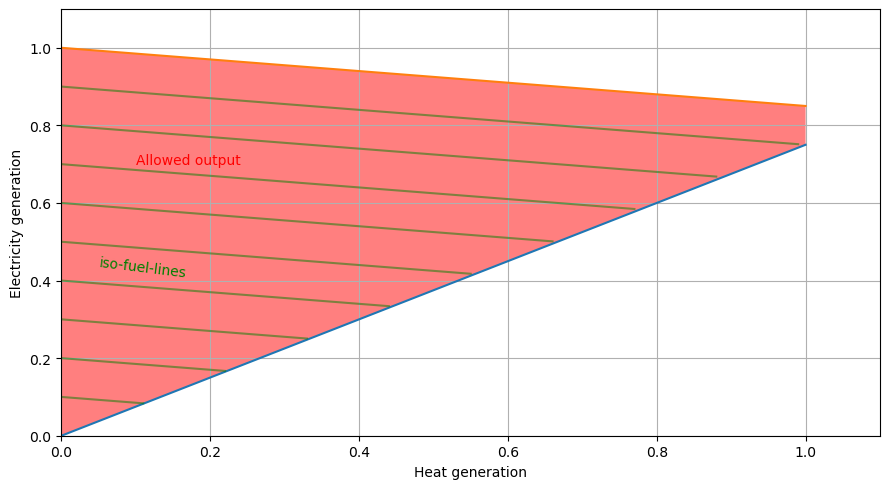

In [36]:
fig, ax = plt.subplots(figsize=(9, 5))

t = 0.01
ph = np.arange(0, 1.0001, t)

ax.plot(ph, c_m * ph)
ax.set_xlabel("Heat generation")
ax.set_ylabel("Electricity generation")
ax.grid(True)

ax.set_xlim([0, 1.1])
ax.set_ylim([0, 1.1])
ax.text(0.1, 0.7, "Allowed output", color="r")
ax.plot(ph, 1 - c_v * ph)

for i in range(1, 10):
    k = 0.1 * i
    x = np.arange(0, k / (c_m + c_v), t)
    ax.plot(x, k - c_v * x, color="g", alpha=0.5)

ax.text(0.05, 0.41, "iso-fuel-lines", color="g", rotation=-7)
ax.fill_between(ph, c_m * ph, 1 - c_v * ph, facecolor="r", alpha=0.5)

fig.tight_layout()

We can build the network and add the buses, loads and links representing the OCGT and CHP unit. We use two idependent link to represent the generation of electricity and heat in the CHP unit and later we will impose constraints limiting the feasible space (as shown in the figure above).

In [37]:
network = pypsa.Network()

network.add("Bus", "electricity")
network.add("Load", "electricity load", bus="electricity", p_set=50)

network.add("Bus", "heat")
network.add("Load", "heat load", bus="heat", p_set=40)

network.add("Bus", "gas")

# We add a gas store with energy capacity and an initial filling level much higher than the required gas consumption, 
# this way gas supply is unlimited
network.add("Store", "gas", e_initial=1e6, e_nom=1e6, bus="gas")


network.add(
    "Link",
    "OCGT",
    bus0="gas",
    bus1="electricity",
    p_nom=1000,
    marginal_cost=20,
    efficiency=0.35,
)

network.add(
    "Link",
    "CHP generator",
    bus0="gas",
    bus1="electricity",
    efficiency=0.3,
    p_nom=1000,
    marginal_cost=20,
)

network.add(
    "Link",
    "CHP boiler",
    bus0="gas",
    bus1="heat",
    p_nom=1000,
)


network.add(
    "Link",
    "gas boiler",
    bus0="gas",
    bus1="heat",
    marginal_cost=20,
    p_nom=1000,
    efficiency=0.9,
)

Index(['gas boiler'], dtype='object')

In [38]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
electricity load,electricity,,,50.0,0.0,-1.0,True
heat load,heat,,,40.0,0.0,-1.0,True


We add the CHP constraints to limite the feasible operation space


In [39]:
# Guarantees isofuel lines, i.e. increase in heat generation is proportional to decrease in electricity generation
network.links.at["CHP boiler", "efficiency"] = (network.links.at["CHP generator", "efficiency"] / c_v)

model = network.optimize.create_model()

link_p = model.variables["Link-p"]

# Guarantees back-pressure line
model.add_constraints(
    c_m * network.links.at["CHP boiler", "efficiency"] * link_p.sel(Link="CHP boiler")
    - network.links.at["CHP generator", "efficiency"] * link_p.sel(Link="CHP generator")
    <= 0,
    name="backpressure",)


# Guarantees top iso fuel line
model.add_constraints(
    link_p.sel(Link="CHP boiler") + link_p.sel(Link="CHP generator")
    - network.links.at["CHP generator", "p_nom"]
    <= 0,
    name="top_iso_fuel_line",
)

network.optimize.solve_model()

Index(['gas'], dtype='object', name='Store')
Index(['electricity', 'heat', 'gas'], dtype='object', name='Bus')
Index(['OCGT', 'CHP generator', 'CHP boiler', 'gas boiler'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.04s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 6 primals, 16 duals
Objective: 3.14e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance, backpressure, top_iso_fuel_line were not assigned to the network.


('ok', 'optimal')

In [40]:
network.links_t.p1

Link,OCGT,CHP generator,CHP boiler,gas boiler
snapshot,,,,
now,-20.0,-30.0,-40.0,0.0
